# Plateforme de recommandation des produits Chanel

On commence par importer les modules nécessaires :

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
from PIL import Image
from io import BytesIO

## Partie 1 : Analyse approfondie du jeu de données

### 1. Exploration initiale

On charge les données :

In [12]:
data = pd.read_parquet('data.parquet')

On prend connaissance des dimensions du dataset :

In [13]:
data.shape

(1428, 17)

On prend aussi connaissance du type de chaque colonne :

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   website_name     1428 non-null   object 
 1   competence_date  1428 non-null   object 
 2   country_code     1428 non-null   object 
 3   currency_code    1428 non-null   object 
 4   brand            1428 non-null   object 
 5   category1_code   1428 non-null   object 
 6   category2_code   1428 non-null   object 
 7   category3_code   1428 non-null   object 
 8   product_code     1428 non-null   object 
 9   title            1428 non-null   object 
 10  itemurl          1428 non-null   object 
 11  imageurl         1428 non-null   object 
 12  full_price       1428 non-null   float64
 13  price            1428 non-null   float64
 14  full_price_eur   1428 non-null   float64
 15  price_eur        1428 non-null   float64
 16  flg_discount     1428 non-null   int64  
dtypes: float64(4),

On vérifie s'il y a des valeurs nulles :

In [15]:
data.isna().sum()

website_name       0
competence_date    0
country_code       0
currency_code      0
brand              0
category1_code     0
category2_code     0
category3_code     0
product_code       0
title              0
itemurl            0
imageurl           0
full_price         0
price              0
full_price_eur     0
price_eur          0
flg_discount       0
dtype: int64

En l'occurence, ce dataset ne comporte pas de valeurs nulles.

Voici un aperçu des 5 premières lignes du dataset :

In [16]:
data.head()

,website_name,competence_date,country_code,currency_code,brand,category1_code,category2_code,category3_code,product_code,title,itemurl,imageurl,full_price,price,full_price_eur,price_eur,flg_discount
0,Chanel,2023-11-17,DEU,EUR,CHANEL,FASHION,HANDBAGS,N.A.,PAS4152B13455,Tweed & goldfarbenes Metall Schwarz Rosa & B...,https://www.chanel.com/de/mode/p/AS4152B13455N...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5200.0,5200.0,5200.0,5200.0,0
1,Chanel,2023-11-17,DEU,EUR,CHANEL,FASHION,HANDBAGS,N.A.,PA67085Y09953,n.a.,https://www.chanel.com/de/mode/p/A67085Y099539...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5750.0,5750.0,5750.0,5750.0,0
2,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,BLUE LIGHT GLASSES,N.A.,PA71441,Schwarz,https://www.chanel.com/de/brillen/p/A71441X081...,https://res.cloudinary.com/dwayrkp5z/image/fet...,420.0,420.0,420.0,420.0,0
3,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,SUNGLASSES,N.A.,PA71449,Silberfarben. Gläser: Braun Mit Verlauf,https://www.chanel.com/de/brillen/p/A71449X099...,https://res.cloudinary.com/dwayrkp5z/image/fet...,580.0,580.0,580.0,580.0,0
4,Chanel,2023-11-17,DEU,EUR,CHANEL,EYEWEAR,SUNGLASSES,N.A.,PA71466,Blau & Rosa. Gläser: Grau Mit Verlauf,https://www.chanel.com/de/brillen/p/A71466X010...,https://res.cloudinary.com/dwayrkp5z/image/fet...,480.0,480.0,480.0,480.0,0


On remarque que certaines colonnes ont l'air d'avoir une seule valeur pour toutes les entrées, on y remédiera dans la prochaine sous-section.

On recueilles les statistiques sur les données quantitatives :

In [17]:
data.describe()

,full_price,price,full_price_eur,price_eur,flg_discount
count,1428.000000,1428.000000,1428.000000,1428.000000,1428.0
mean,6076.253725,6076.253725,6076.253725,6076.253725,0.0
std,15219.005999,15219.005999,15219.005999,15219.005999,0.0
min,23.000000,23.000000,23.000000,23.000000,0.0
25%,195.000000,195.000000,195.000000,195.000000,0.0
50%,1415.000000,1415.000000,1415.000000,1415.000000,0.0
75%,5800.000000,5800.000000,5800.000000,5800.000000,0.0
max,142000.000000,142000.000000,142000.000000,142000.000000,0.0


On remarque que ces colonnes présentent les mêmes statistiques, il est possible que ces quatres colonnes comportent les mêmes valeurs pour chaque entrée. On vérifie cela :

In [18]:
colonnes = ['full_price', 'price', 'full_price_eur', 'price_eur']
(data[colonnes].nunique(axis=1)==1).all()

True

Ces quatres colonnes sont effectivement identiques.

On écrit une fonction pour analyser la qualité et la diversité des images (dimensions, couleurs, formats) :

In [19]:
def analyze_image_quality(df, sample_size=50):
    print(f"Analyse de {sample_size} images aléatoires :")
    sample = df.sample(sample_size, random_state=42)
    widths = []
    heights = []
    modes = []
    
    for _, row in sample.iterrows():
        try:
            response = requests.get(row['imageurl'], timeout=3)
            img = Image.open(BytesIO(response.content))
            w, h = img.size
            widths.append(w)
            heights.append(h)
            modes.append(img.mode)
        except Exception as e:
            print(f"Erreur de chargement pour {row['product_code']}")

    # Visualisation des dimensions
    plt.figure(figsize=(10, 5))
    plt.scatter(widths, heights, alpha=0.6, c='blue')
    plt.title(f"Dimensions des images (Echantillon n={sample_size})")
    plt.xlabel("Largeur (px)")
    plt.ylabel("Hauteur (px)")
    plt.show()
    
    print(f"Dimensions uniques trouvées : {set(zip(widths, heights))}")
    print(f"Modes de couleurs trouvés : {set(modes)}")

On lance l'analyse :

Analyse de 50 images aléatoires :
Erreur de chargement pour PJ12307
Erreur de chargement pour PAP3604B14342
Erreur de chargement pour PJ12118
Erreur de chargement pour PP140730
Erreur de chargement pour PAP0953B04852
Erreur de chargement pour PPH6593
Erreur de chargement pour PJ12157
Erreur de chargement pour PP140680
Erreur de chargement pour PPH7609
Erreur de chargement pour PP120900
Erreur de chargement pour PP143030
Erreur de chargement pour PP107809
Erreur de chargement pour PJ12071
Erreur de chargement pour PP102940
Erreur de chargement pour PJ12091
Erreur de chargement pour PP102440
Erreur de chargement pour PA92193Y09953
Erreur de chargement pour PA71547
Erreur de chargement pour PP144260
Erreur de chargement pour PP126300
Erreur de chargement pour PG31318Y50006
Erreur de chargement pour PA75272
Erreur de chargement pour PP147540


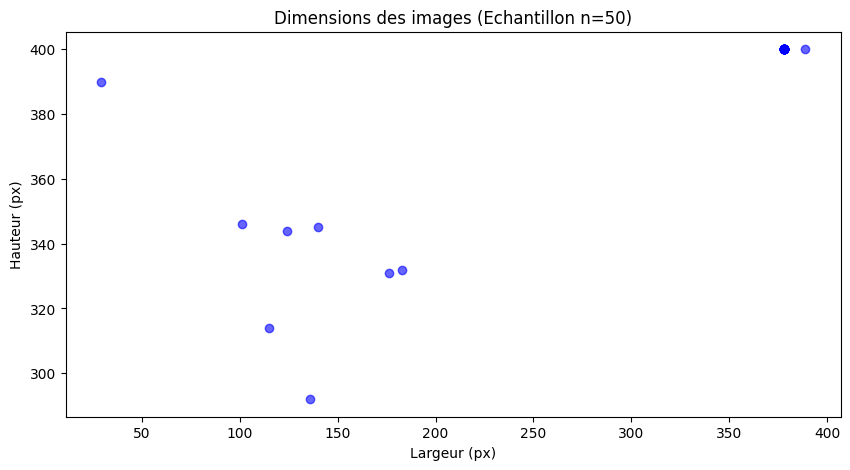

Dimensions uniques trouvées : {(183, 332), (140, 345), (176, 331), (124, 344), (115, 314), (136, 292), (378, 400), (389, 400), (101, 346), (29, 390)}
Modes de couleurs trouvés : {'P', 'RGB'}


In [20]:
analyze_image_quality(data, sample_size=50)

On remarque qu'on a des erreurs de chargement sur certaines images. En fait, ces images ne sont pas accessibles.

Aussi, les images ont des tailles très variées et des rations différents. Il faudra sûrement implémenter une étape de redimensionnement et probablement de padding pour ne pas déformer les images tout en les adaptant à un format convenable pour certains modèles de deep learning (comme ResNet ou les CNN).

Enfin, il y a des images en RGB, mais il y en a aussi en P (Palette). Il faudra convertir ces dernières en RGB pour les modèles de vision.

### 2. Préparation des données

On supprime les colonnes pour lesquelles la même valeur est présente pour toutes les entrées :

In [21]:
for colonne in data.columns:
    if data[colonne].nunique() == 1 :
        data.drop(colonne, axis = 1, inplace = True)
        print("La colonne " + colonne + "a été supprimée")

La colonne website_namea été supprimée
La colonne competence_datea été supprimée
La colonne country_codea été supprimée
La colonne currency_codea été supprimée
La colonne branda été supprimée
La colonne category3_codea été supprimée
La colonne flg_discounta été supprimée


On ne garde aussi qu'une seule colonne parmi `full_price`, `price`, `full_price_eur`, et `price_eur` puisqu'elles sont identiques :

In [22]:
colonnes = ['full_price','full_price_eur', 'price_eur']
data.drop(colonnes, axis=1, inplace=True)

Voici un aperçu du dataframe nettoyé :

In [23]:
data.head()

,category1_code,category2_code,product_code,title,itemurl,imageurl,price
0,FASHION,HANDBAGS,PAS4152B13455,Tweed & goldfarbenes Metall Schwarz Rosa & B...,https://www.chanel.com/de/mode/p/AS4152B13455N...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5200.0
1,FASHION,HANDBAGS,PA67085Y09953,n.a.,https://www.chanel.com/de/mode/p/A67085Y099539...,https://res.cloudinary.com/dwayrkp5z/image/fet...,5750.0
2,EYEWEAR,BLUE LIGHT GLASSES,PA71441,Schwarz,https://www.chanel.com/de/brillen/p/A71441X081...,https://res.cloudinary.com/dwayrkp5z/image/fet...,420.0
3,EYEWEAR,SUNGLASSES,PA71449,Silberfarben. Gläser: Braun Mit Verlauf,https://www.chanel.com/de/brillen/p/A71449X099...,https://res.cloudinary.com/dwayrkp5z/image/fet...,580.0
4,EYEWEAR,SUNGLASSES,PA71466,Blau & Rosa. Gläser: Grau Mit Verlauf,https://www.chanel.com/de/brillen/p/A71466X010...,https://res.cloudinary.com/dwayrkp5z/image/fet...,480.0


### 3. Visualisation

On représente la distribution des catégories :

<Axes: ylabel='count'>

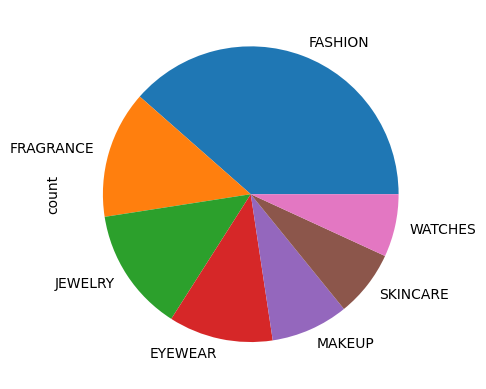

In [24]:
data.category1_code.value_counts().plot.pie()

In [25]:
data.category2_code.value_counts()

category2_code
READY-TO-WEAR                  243
COSTUME JEWELRY                127
SUNGLASSES                      99
WOMEN                           88
WATCHES                         87
MEN                             72
HANDBAGS                        61
COCO CRUSH                      54
SHOES                           42
FACE                            41
EYEGLASSES                      40
SMALL LEATHER GOODS             38
BATH AND BODY                   36
MOISTURIZERS                    35
EYES                            35
RINGS                           35
NECKLACES                       30
BRUSHES AND ACCESSORIES         26
EARRINGS                        26
BLUE LIGHT GLASSES              24
LIPS                            21
N°5                             15
TONERS & LOTIONS                11
EXCEPTIONAL PIECES              11
CLEANSERS & MAKEUP REMOVERS     11
BELTS                           10
HEADWEAR                         9
OILS                             9
BRACE

/var/folders/zv/2djxbbx13ysbr2pfl27pgp680000gn/T/ipykernel_62791/665404679.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cats.values, y=top_cats.index, palette='viridis')


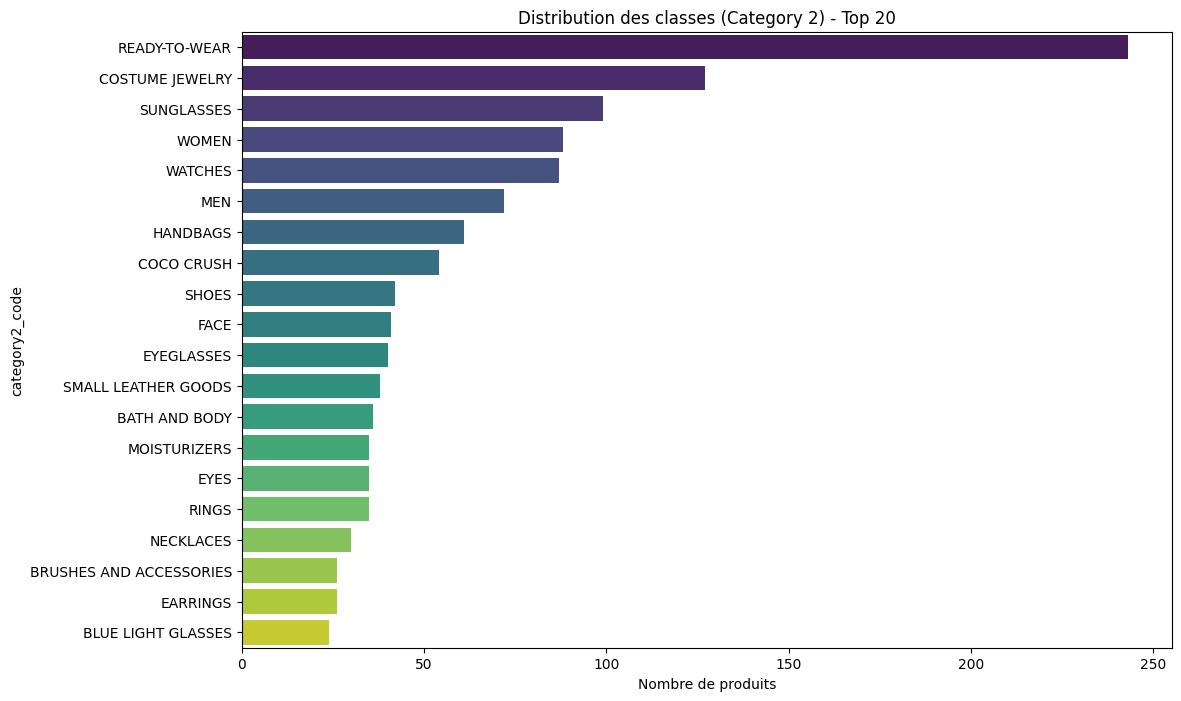

La classe majoritaire (READY-TO-WEAR) représente 17.0% du dataset.


In [26]:
plt.figure(figsize=(12, 8))
# On affiche le Top 20 des catégories pour la lisibilité
top_cats = data['category2_code'].value_counts().nlargest(20)
sns.barplot(x=top_cats.values, y=top_cats.index, palette='viridis')
plt.title('Distribution des classes (Category 2) - Top 20')
plt.xlabel('Nombre de produits')
plt.show()

# Analyse du biais
print(f"La classe majoritaire ({top_cats.index[0]}) représente {top_cats.iloc[0]/len(data):.1%} du dataset.")

On remarque que la distribution de `category2_code` est très hétérogène.

On représente la distribution des prix :

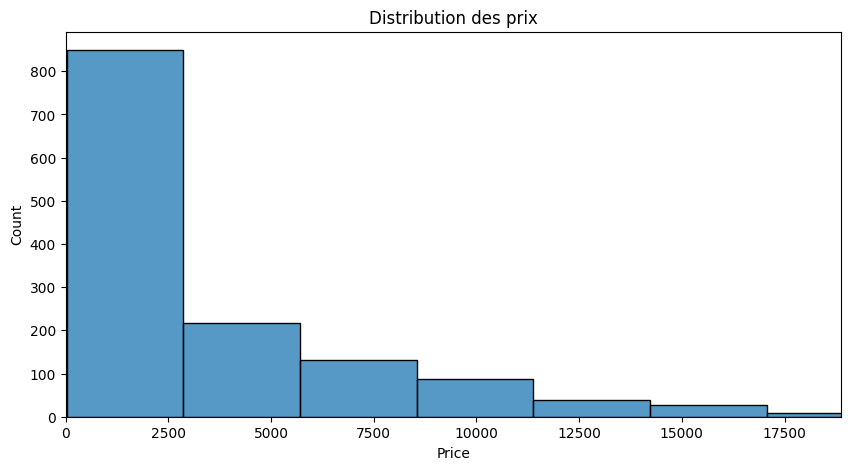

In [27]:
plt.figure(figsize=(10, 5))
sns.histplot(data['price'], bins=50)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Distribution des prix')
plt.xlim(0, data['price'].quantile(0.95)) # On coupe les valeurs extrêmes pour y voir clair
plt.show()

Voici les cinq produits les plus chers :

In [28]:
data.nlargest(5,'price')

,category1_code,category2_code,product_code,title,itemurl,imageurl,price
1216,JEWELRY,RINGS,PJ63142,18 Karat Weißgold Diamanten schwarze Spinelle,https://www.chanel.com/de/schmuck/p/J63142/com...,https://res.cloudinary.com/dwayrkp5z/image/fet...,142000.0
790,JEWELRY,LES INTEMPORELS DE CHANEL,PJ60909,18 Karat Weißgold Diamanten,https://www.chanel.com/de/schmuck/p/J60909/rub...,https://res.cloudinary.com/dwayrkp5z/image/fet...,132000.0
1332,WATCHES,EXCEPTIONAL PIECES,PPH7431,Extrem widerstandsfähige weiße Keramik und Wei...,https://www.chanel.com/de/uhren/p/H7431/j12-ba...,https://res.cloudinary.com/dwayrkp5z/image/fet...,130000.0
788,JEWELRY,BRACELETS,PJ2831,18 Karat Weißgold Diamanten,https://www.chanel.com/de/schmuck/p/J2831/come...,https://res.cloudinary.com/dwayrkp5z/image/fet...,123000.0
437,WATCHES,EXCEPTIONAL PIECES,PPH6949,Großes Modell BEIGEGOLD und Diamanten goldbr...,https://www.chanel.com/de/uhren/p/H6949/boy-fr...,https://res.cloudinary.com/dwayrkp5z/image/fet...,120000.0


On représente les longueurs des titres :

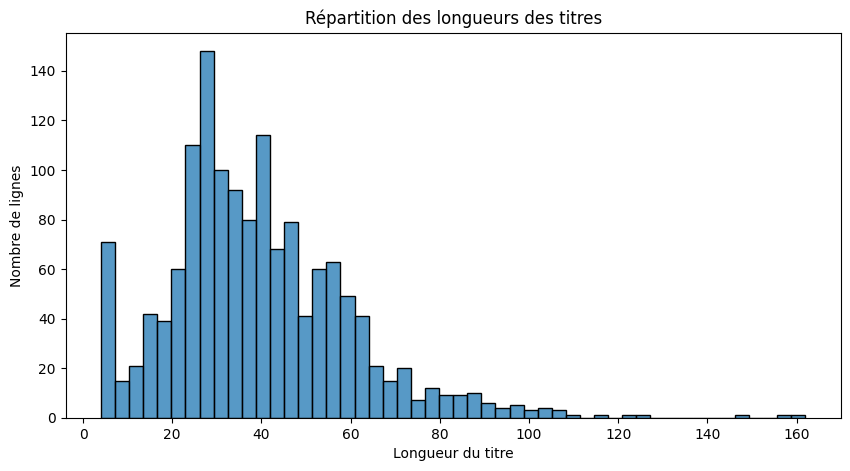

In [29]:
plt.figure(figsize=(10,5))
sns.histplot(data['title'].str.len(), bins=50)
plt.xlabel('Longueur du titre')
plt.ylabel('Nombre de lignes')
plt.title('Répartition des longueurs des titres')
plt.show()

On nettoie les titres en mettant tout en minuscule et en supprimant les espaces avant/après :

In [30]:
data['clean_title'] = data['title'].str.lower().str.strip()

On vérifie la présence de doublons dans les titres :

In [31]:
duplicates = data[data.duplicated(subset=['clean_title'], keep=False)]
print(f"Nombre de titres dupliqués : {len(duplicates)}")
print(f"Proportion de titres dupliqués : {len(duplicates)/len(data['title']):.2%}")

Nombre de titres dupliqués : 806
Proportion de titres dupliqués : 56.44%


Il y a 56.44 % de titres dupliqués. C'est un chiffre très élevé. Cela signifie que notre modèle textuel aura beaucoup de mal à distinguer les produits. Si l'utilisateur tape un titre, le système textuel verra 50 articles identiques. Le texte seul est donc insuffisant pour discriminer les produits, l'image (qui montre la couleur spécifique) sera donc nécessaire.

On visualise les tittres nettoyés :

In [32]:
display(data[['title', 'clean_title']].head())

,title,clean_title
0,Tweed & goldfarbenes Metall Schwarz Rosa & B...,tweed & goldfarbenes metall schwarz rosa & b...
1,n.a.,n.a.
2,Schwarz,schwarz
3,Silberfarben. Gläser: Braun Mit Verlauf,silberfarben. gläser: braun mit verlauf
4,Blau & Rosa. Gläser: Grau Mit Verlauf,blau & rosa. gläser: grau mit verlauf


On écrit une fonction pour afficher cinq exemples de produits pour les trois catégories les plus fréquentes :

In [33]:
def show_category_examples(df, category_col='category2_code', n_examples=5):
    top_categories = df[category_col].value_counts().head(3).index.tolist()
    
    for cat in top_categories:
        print(f"Catégorie : {cat}")
        subset = df[df[category_col] == cat].sample(n_examples)
        
        plt.figure(figsize=(15, 5))
        for i, (_, row) in enumerate(subset.iterrows()):
            try:
                response = requests.get(row['imageurl'], timeout=3)
                img = Image.open(BytesIO(response.content))
                
                plt.subplot(1, n_examples, i+1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"{row['price']}€", fontsize=10)
            except:
                pass
        plt.show()

On exécute cette fonction d'affichage :

Catégorie : READY-TO-WEAR


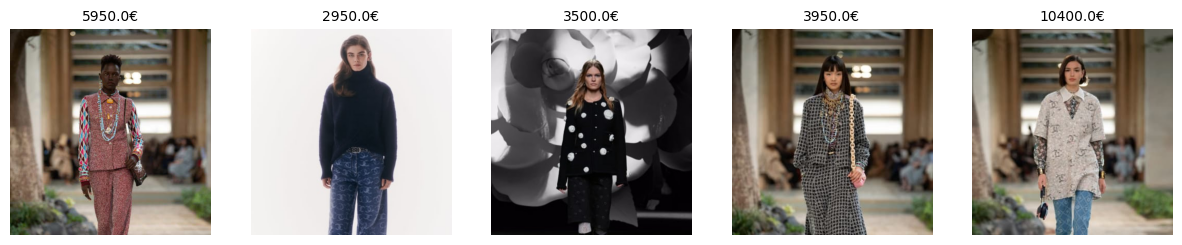

Catégorie : COSTUME JEWELRY


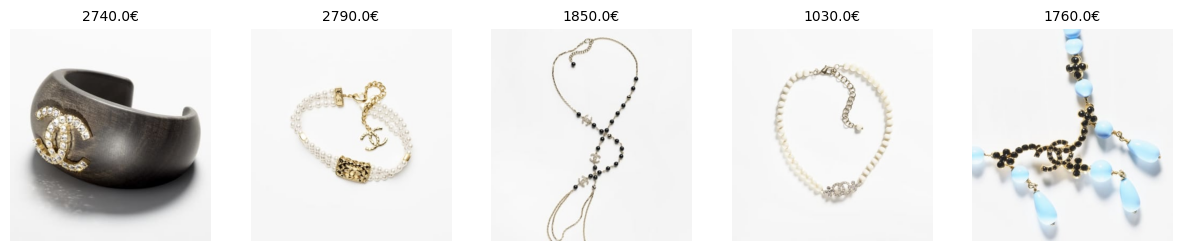

Catégorie : SUNGLASSES


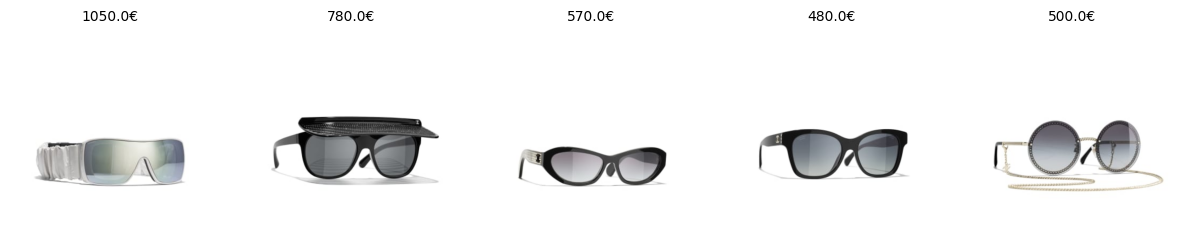

In [34]:
show_category_examples(data)

On note que les correspondances entre les images, les descriptions et les catégories sont cohérentes.

On représente la distribution des prix par catégorie  sous la forme d'une boîte à moustache :

/var/folders/zv/2djxbbx13ysbr2pfl27pgp680000gn/T/ipykernel_62791/4028035275.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_filtered, x='price', y='category2_code', palette="viridis")


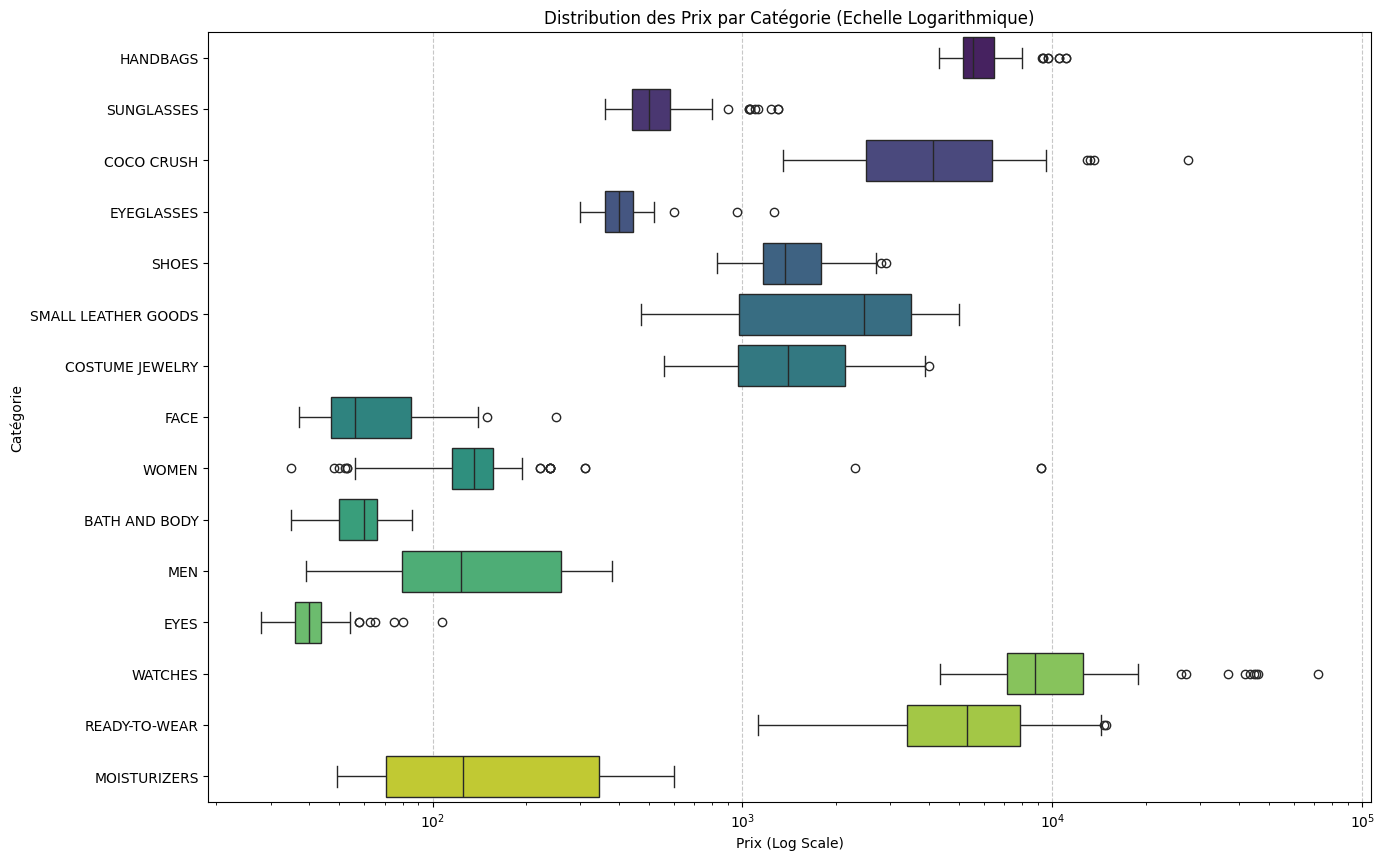

In [35]:
# Configuration de la taille
plt.figure(figsize=(15, 10))

# On ne garde que les catégories avec assez de produits pour que le graph soit lisible
top_cats_list = data['category2_code'].value_counts().nlargest(15).index
data_filtered = data[data['category2_code'].isin(top_cats_list)]

# Création du Boxplot
sns.boxplot(data=data_filtered, x='price', y='category2_code', palette="viridis")

# Affichage en échelle logarithmique
plt.xscale('log') 
plt.title('Distribution des Prix par Catégorie (Echelle Logarithmique)')
plt.xlabel('Prix (Log Scale)')
plt.ylabel('Catégorie')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

On remarque que les montres représentent la catégorie avec la plus grande dispersion. Cela montre que Chanl vend à la fois des montres abordables et des pièces de haute horlogerie. Concernant les sacs, la médiane de cette catégorie est très élevée, cela signifie qu'il n'y a pas de sac "pas cher" chez Chanel.

En tout cas, cette visualisation met en évidence une segmentation tarifaire en trois tiers : les cosmétiques (entrée de gamme), les accessoires de mode (milieu de gamme), et les pièces de haute valeur (haut de gamme).

## Partie 2 : Comparaison des embeddings visuels

### 1. Méthodes pour extraire les embeddings visuels

#### Méthode 1 : Modèle entraîné pour la classification

#### Méthode 2 : Utilisation d’un modèle pré-entraîné

#### Méthode 3 : Self-supervised learning

### 2. Comparaison des trois méthodes

## Partie 3 : Analyse et comparaison des embeddings textuels

### 1. Traduction des descriptions

In [36]:
import requests
from tqdm import tqdm

API_KEY = "0f6b7853-5567-4c01-a117-98b90787e917:fx"
DEEPL_URL = "https://api-free.deepl.com/v2/translate"

def deepl_translate(text):
    payload = {
        "auth_key": API_KEY,
        "text": text,
        "source_lang": "DE",
        "target_lang": "EN"
    }
    response = requests.post(DEEPL_URL, data=payload)
    return response.json()["translations"][0]["text"]

english_titles = []
for title in tqdm(data["title"]):
    try:
        english_titles.append(deepl_translate(title))
    except:
        english_titles.append("")

data["english_title"] = english_titles


100%|██████████| 1428/1428 [12:11<00:00,  1.95it/s]


In [37]:
# affichage aleatoire de 10 titres traduits
import random
for i in random.sample(range(len(data)), 10):
    print(f"DE: {data.iloc[i]['title']}")
    print(f"EN: {data.iloc[i]['english_title']}")
    print()

DE: Schwarz & goldfarben. Gläser: Grau
EN: Black & gold-colored. Lenses: Gray

DE: Metall  Glasperlen  Modeschmuckperlen & Strass  Goldfarben  Perlmuttweiß & Kristall
EN: Metal glass beads costume jewelry beads & rhinestones gold pearl white & crystal

DE: EAU DE TOILETTE ZERSTÄUBER
EN: EAU DE TOILETTE ATOMIZER

DE: Metall & Glasperlen  Goldfarben & Orange
EN: Metal & glass beads Gold-colored & orange

DE: Seidentwill  Beige  Schwarz & Weiß
EN: Silk twill beige black & white

DE: TOPCOAT
EN: TOPCOAT

DE: Metall  Harz & Glasperlen  Goldfarben & Braun
EN: Metal resin & glass beads Gold-colored & brown

DE: Schwarz. Gläser: Transparent
EN: Black. Lenses: Transparent

DE: EAU DE TOILETTE ZERSTÄUBER
EN: EAU DE TOILETTE ATOMIZER

DE: Kleines Modell  BEIGEGOLD und Diamanten  Kalbslederarmband mit Steppmuster. Inklusive zweites Armband.
EN: Small model BEIGEGOLD and diamonds Calfskin bracelet with quilted pattern. Includes second bracelet.



In [41]:
pd.DataFrame({'english_title': english_titles}).to_csv('titles_en.csv', index=False)

### 2. Génération des embeddings textuels

In [ ]:
# %% [markdown]
# ### 2. Embeddings textuels — Sentence-BERT (version sans TF/Keras)

# %%
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import numpy as np

# Charger le même modèle que Sentence-BERT mais via Transformers
model_name = "sentence-transformers/all-MiniLM-L6-v2"
print("📦 Loading MiniLM (Sentence-BERT) via Transformers…")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device("cpu")
model.to(device)

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * mask, dim=1) / torch.clamp(mask.sum(dim=1), min=1e-9)

def encode_texts(texts):
    all_embeddings = []
    for t in tqdm(texts):
        encoded = tokenizer(t, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            output = model(**encoded)

        embedding = mean_pooling(output, encoded["attention_mask"])
        embedding = embedding.squeeze().cpu().numpy()
        all_embeddings.append(embedding)

    return np.array(all_embeddings)


titles_en = data["english_title"].tolist()

print("🚀 Encoding Sentence-BERT embeddings…")
embeddings_sbert = encode_texts(titles_en)

data["embedding_sbert"] = embeddings_sbert.tolist()

embeddings_sbert.shape


/opt/miniconda3/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📦 Loading MiniLM (Sentence-BERT) via Transformers…


### 3. Analyse des embeddings

In [ ]:
# %% [markdown]
# ### 3. Analyse des embeddings textuels — distances cosines

# %%
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Matrix of embeddings SBERT (N, 384)
X = np.vstack(data["embedding_sbert"].values)

# Matrice de similarité cosinus (N x N)
similarity_matrix = cosine_similarity(X)


In [ ]:
idx = data[data["english_title"].str.contains("Perfume", case=False)].index[0]
query_title = data.loc[idx, "english_title"]

print("Produit choisi :", query_title)


Produit choisi : PERFUME POCKET ATOMIZER


In [ ]:
# On trie par similarité décroissante
similar_indices = similarity_matrix[idx].argsort()[::-1]

print("\n PRODUITS LES PLUS SIMILAIRES TEXTUELLEMENT :\n")
for i in similar_indices[1:6]:   # on ignore l’item lui-même (similarité=1)
    print(f"{data.loc[i,'english_title']}  —  sim={similarity_matrix[idx][i]:.3f}")



 PRODUITS LES PLUS SIMILAIRES TEXTUELLEMENT :

PERFUME ATOMIZER  —  sim=0.908
REFILLABLE PERFUME POCKET ATOMIZER  —  sim=0.883
COLOGNE ATOMIZER  —  sim=0.784
EAU DE PARFUM REFILLABLE POCKET ATOMIZER  —  sim=0.705
PERFUME TWIST AND SPRAY  —  sim=0.640


In [ ]:
print("\nPRODUITS LES PLUS ÉLOIGNÉS TEXTUELLEMENT :\n")
for i in similar_indices[-5:]:
    print(f"{data.loc[i,'english_title']}  —  sim={similarity_matrix[idx][i]:.3f}")



PRODUITS LES PLUS ÉLOIGNÉS TEXTUELLEMENT :

LES EXCLUSIFS DE CHANEL  —  sim=-0.025
White. Lenses: Gray with gradient  —  sim=-0.030
White. Lenses: Gray with gradient  —  sim=-0.030
White. Lenses: Gray with gradient  —  sim=-0.030
White. Lenses: Gray with gradient  —  sim=-0.030


### 4. Visualisation